# [How to do Unsupervised Clustering with Keras](https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/) | DLology

Read my blog post for details.

In [56]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)

In [57]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import metrics

In [58]:

def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [59]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)

In [60]:
n_clusters = len(np.unique(y))
x.shape

(70000, 784)

## Base line K-Means clustering accuracy

In [61]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x)

In [62]:
metrics.acc(y, y_pred_kmeans)

0.5322857142857143

## Defining hyperparameters

In [65]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 1
batch_size = 256
save_dir = 'results/'

In [66]:
autoencoder, encoder = autoencoder(dims, init=init)

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

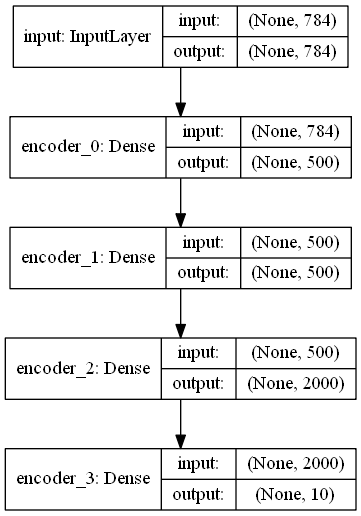

In [11]:
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png') 

## Pretrain auto-encoder

In [67]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/1
70000/70000 [==============================] - 7s 95us/step - loss: 0.0647


In [68]:
autoencoder.save_weights(save_dir + '/ae_weights.h5')

### Load the pre-trained auto encoder weights

In [69]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

## Build clustering model

### ClusteringLayer

In [70]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [71]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

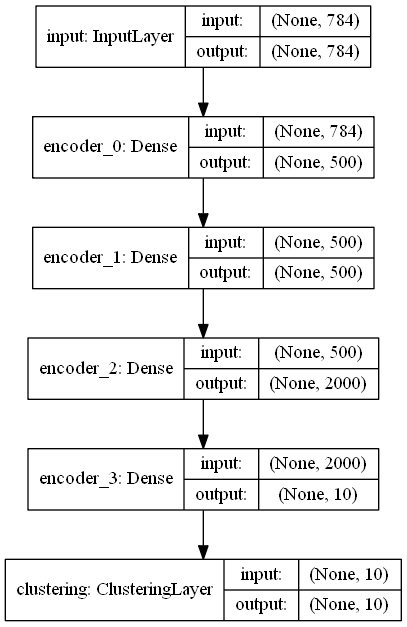

In [17]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 


In [72]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

### Step 1: initialize cluster centers using k-means

In [73]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [74]:
y_pred_last = np.copy(y_pred)

In [75]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Step 2: deep clustering
Compute p_i by first raising q_i to the second power and then normalizing by frequency per cluster:

In [76]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [77]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [78]:
tol = 0.001 # tolerance threshold to stop training

### Start training

In [79]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

Iter 0: acc = 0.35754, nmi = 0.31129, ari = 0.21638  ; loss= 0
Iter 140: acc = 0.36579, nmi = 0.30890, ari = 0.21965  ; loss= 0.10267
Iter 280: acc = 0.36870, nmi = 0.30488, ari = 0.22011  ; loss= 0.12351
Iter 420: acc = 0.36813, nmi = 0.30301, ari = 0.21822  ; loss= 0.1469
Iter 560: acc = 0.36844, nmi = 0.30138, ari = 0.21667  ; loss= 0.16663
Iter 700: acc = 0.36916, nmi = 0.30196, ari = 0.21716  ; loss= 0.18302
Iter 840: acc = 0.36943, nmi = 0.30169, ari = 0.21720  ; loss= 0.19911
Iter 980: acc = 0.36854, nmi = 0.30132, ari = 0.21692  ; loss= 0.21176
Iter 1120: acc = 0.36807, nmi = 0.29996, ari = 0.21568  ; loss= 0.22109
Iter 1260: acc = 0.36696, nmi = 0.29855, ari = 0.21242  ; loss= 0.21644
Iter 1400: acc = 0.36657, nmi = 0.29810, ari = 0.21089  ; loss= 0.21943
Iter 1540: acc = 0.36419, nmi = 0.29951, ari = 0.21084  ; loss= 0.22348
Iter 1680: acc = 0.36289, nmi = 0.29846, ari = 0.21047  ; loss= 0.21397
Iter 1820: acc = 0.36306, nmi = 0.29916, ari = 0.21156  ; loss= 0.21681
Iter 1960

### Load the clustering model trained weights

In [80]:
model.load_weights(save_dir + '/DEC_model_final.h5')

### Final Evaluation

In [81]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.37807, nmi = 0.31678, ari = 0.22979  ; loss= 0.1373


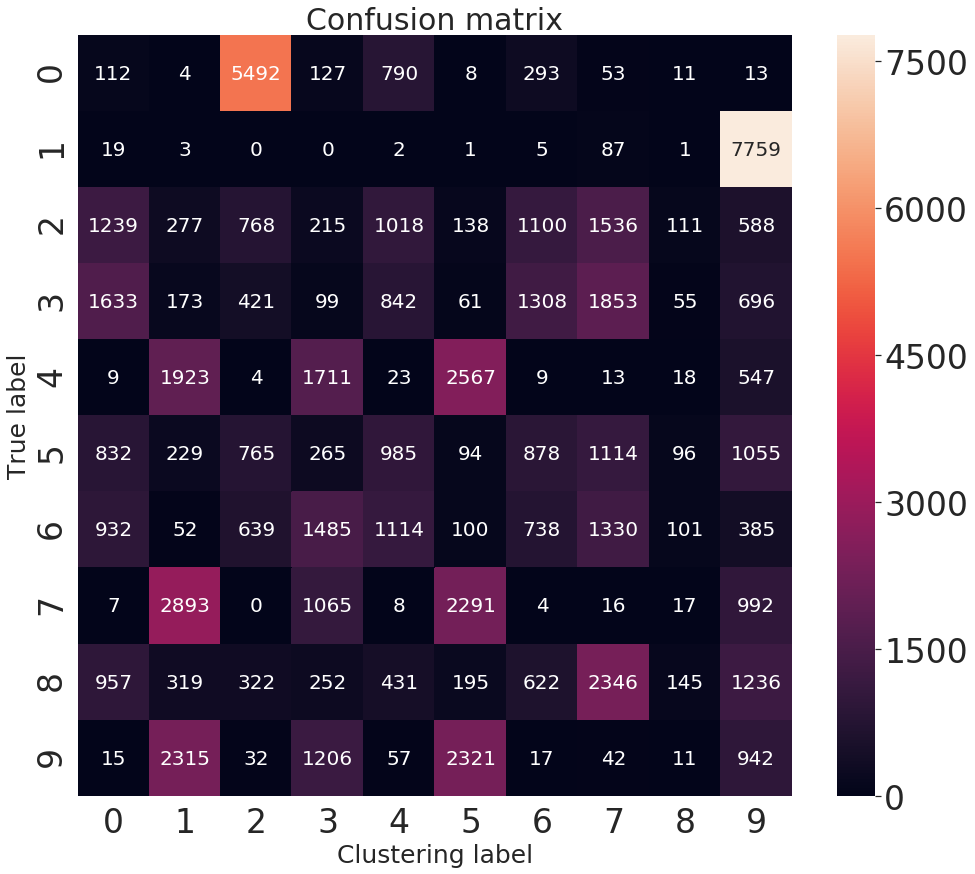

In [82]:
import seaborn as sns
import matplotlib 
%matplotlib inline

import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

### Break down Accuracy metric

linear assignment- [Munkres' Assignment Algorithm](http://csclab.murraystate.edu/~bob.pilgrim/445/munkres.html)

In [83]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

0.37807142857142856

In [30]:
w

array([[   0, 7656,    9,    2,    4,    3,   10,   22,   16,    9],
       [   1,   23,   45,   50,    6,    0,    0, 6976,    5,  110],
       [   4,   22,   48, 6796,    0,   83,    1,    5,   61,  121],
       [6813,    2,   21,    3,    4,   31,   33,    7,   18,   29],
       [  38,   41,   59,   58,    8,   25,    9,    4, 6512,   64],
       [  12,   14,   11,   14,   90,   34,    0,  119,  108, 6491],
       [   5,    3,    1,  107,    0, 6080,  165,    1,   49,   20],
       [  22,    4,   12,    5,   40,   39, 6642,    0,   12,    5],
       [   4,   96, 6737,  105,   13,   12,    5,  113,   26,    6],
       [   4,   16,   47,    1, 6659,    6,   11,   46,   18,  103]],
      dtype=int64)

In [31]:
ind

array([[0, 1],
       [1, 7],
       [2, 3],
       [3, 0],
       [4, 8],
       [5, 9],
       [6, 5],
       [7, 6],
       [8, 2],
       [9, 4]])

In [32]:
w.argmax(1)

array([1, 7, 3, 0, 8, 9, 5, 6, 2, 4], dtype=int64)

In [84]:
def vis_data(x_train_encoded, y_train, vis_dim, n_predict, n_train, build_anim):
    cmap = plt.get_cmap('rainbow', 10)

    # 3-dim vis: show one view, then compile animated .gif of many angled views
    if vis_dim == 3:
        # Simple static figure
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        p = ax.scatter3D(x_train_encoded[:,0], x_train_encoded[:,1], x_train_encoded[:,2], 
                c=y_train[:n_predict], cmap=cmap, edgecolor='black')
        fig.colorbar(p, drawedges=True)
        plt.show()

        # Build animation from many static figures
        if build_anim:
            angles = np.linspace(180, 360, 20)
            i = 0
            for angle in angles:
                fig = plt.figure()
                ax = plt.axes(projection='3d')
                ax.view_init(10, angle)
                p = ax.scatter3D(x_train_encoded[:,0], x_train_encoded[:,1], x_train_encoded[:,2], 
                        c=y_train[:n_predict], cmap=cmap, edgecolor='black')
                fig.colorbar(p, drawedges=True)
                outfile = 'anim/3dplot_step_' + chr(i + 97) + '.png'
                plt.savefig(outfile, dpi=96)
                i += 1
            call(['convert', '-delay', '50', 'anim/3dplot*', 'anim/3dplot_anim_' + str(n_train) + '.gif'])

    # 2-dim vis: plot and colorbar.
    elif vis_dim == 2:
        plt.scatter(x_train_encoded[:,0], x_train_encoded[:,1], 
                c=y_train[:n_predict], edgecolor='black', cmap=cmap)
        plt.colorbar(drawedges=True)
        plt.show()

In [87]:
# Encode a number of MNIST digits, then perform t-SNE dim-reduction.
x_train_predict = encoder.predict(x)

#print "Performing t-SNE dimensionality reduction..."
x_train_encoded = TSNE(n_components=2).fit_transform(x_train_predict)
#np.save('%sx_%sdim_tnse_%s.npy' % (266, 2, 266), x_train_encoded)
#x_train_encoded = np.load(s

## Experimental
Convolutional auto encoder.

In [86]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np
from time import time
from keras.datasets import mnist
import numpy as np
np.random.seed(10)
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import metrics

from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np
import os 
from keras.preprocessing.image import load_img
from skimage import transform 
import _pickle as cPickle
import _pickle 
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline
import gzip
from skimage import transform 
import numpy as np
from PIL import Image
import matplotlib
import os
# For plotting graphs via ssh with no display
# Ref: https://stackoverflow.com/questions/2801882/generating-a-png-with-matplotlib-when-display-is-undefined
matplotlib.use('Agg')
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
from numpy import float32
from sklearn import metrics
from sklearn.cluster.k_means_ import KMeans
from sklearn import manifold
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn import preprocessing
from sklearn.utils import shuffle

### Convolutional auto encoder option 1
Use [`Conv2DTranspose`](https://keras.io/layers/convolutional/#conv2dtranspose) to reconstruct the image.

In [37]:
def autoencoderConv2D_1(input_shape=(28, 28, 1), filters=[32, 64, 128, 10]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

### Convolutional auto encoder option 2
Use [`UpSampling2D`](https://keras.io/layers/convolutional/#upsampling2d) to reconstruct the image.

In [38]:
def autoencoderConv2D_2(img_shape=(28, 28, 1)):
    """
    Conv2D auto-encoder model.
    Arguments:
        img_shape: e.g. (28, 28, 1) for MNIST
    return:
        (autoencoder, encoder), Model of autoencoder and model of encoder
    """
    input_img = Input(shape=img_shape)
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    shape_before_flattening = K.int_shape(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    x = Flatten()(x)
    encoded = Dense(10, activation='relu', name='encoded')(x)

    # Decoder
    x = Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(encoded)
    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape(shape_before_flattening[1:])(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


### Pick a convolutional autoencoder
`autoencoderConv2D_1` or `autoencoderConv2D_2`

In [39]:
autoencoder, encoder = autoencoderConv2D_1()

In [40]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
embedding (Dense)            (None, 10)                11530     
_________________________________________________________________
dense_1 (Dense)              (None, 1152)              12672     
__________

### Load MNIST data for convolutional input

In [41]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape(x.shape + (1,))
x = np.divide(x, 255.)

### Pretrain covolutional autoencoder

In [42]:
pretrain_epochs = 1
batch_size = 256

In [43]:
autoencoder.compile(optimizer='adadelta', loss='mse')

In [44]:
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')

Epoch 1/1
70000/70000 [==============================] - 18s 257us/step - loss: 0.0806


In [45]:
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')

### Build clustering model with convolutional autoencoder

In [46]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer='adam', loss='kld')

### Step 1: initialize cluster centers using k-means

In [47]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [48]:
y_pred_last = np.copy(y_pred)

In [49]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Step 2: deep clustering

In [50]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [51]:
tol = 0.001 # tolerance threshold to stop training

### Start training

In [52]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/conv_DEC_model_final.h5')

Iter 0: acc = 0.17790, nmi = 0.09404, ari = 0.04331  ; loss= 0
Iter 140: acc = 0.19464, nmi = 0.09231, ari = 0.05645  ; loss= 0.04275
Iter 280: acc = 0.20307, nmi = 0.09113, ari = 0.06781  ; loss= 0.08927
Iter 420: acc = 0.20510, nmi = 0.08965, ari = 0.07272  ; loss= 0.10816
Iter 560: acc = 0.20861, nmi = 0.08973, ari = 0.07678  ; loss= 0.10953
Iter 700: acc = 0.21019, nmi = 0.08847, ari = 0.07844  ; loss= 0.12989
Iter 840: acc = 0.21203, nmi = 0.08869, ari = 0.07976  ; loss= 0.14549
Iter 980: acc = 0.21359, nmi = 0.08836, ari = 0.08114  ; loss= 0.16048
Iter 1120: acc = 0.21196, nmi = 0.08659, ari = 0.08042  ; loss= 0.18794
Iter 1260: acc = 0.21286, nmi = 0.08561, ari = 0.08077  ; loss= 0.16438
Iter 1400: acc = 0.21324, nmi = 0.08554, ari = 0.08100  ; loss= 0.17467
Iter 1540: acc = 0.21259, nmi = 0.08502, ari = 0.08059  ; loss= 0.17199
Iter 1680: acc = 0.21560, nmi = 0.08741, ari = 0.08261  ; loss= 0.19959
Iter 1820: acc = 0.21729, nmi = 0.08825, ari = 0.08359  ; loss= 0.18546
Iter 196

### Load the clustering model trained weights

In [53]:
model.load_weights(save_dir + '/conv_DEC_model_final.h5')

### Final Evaluation

In [54]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.21780, nmi = 0.08737, ari = 0.08194  ; loss= 0.13141


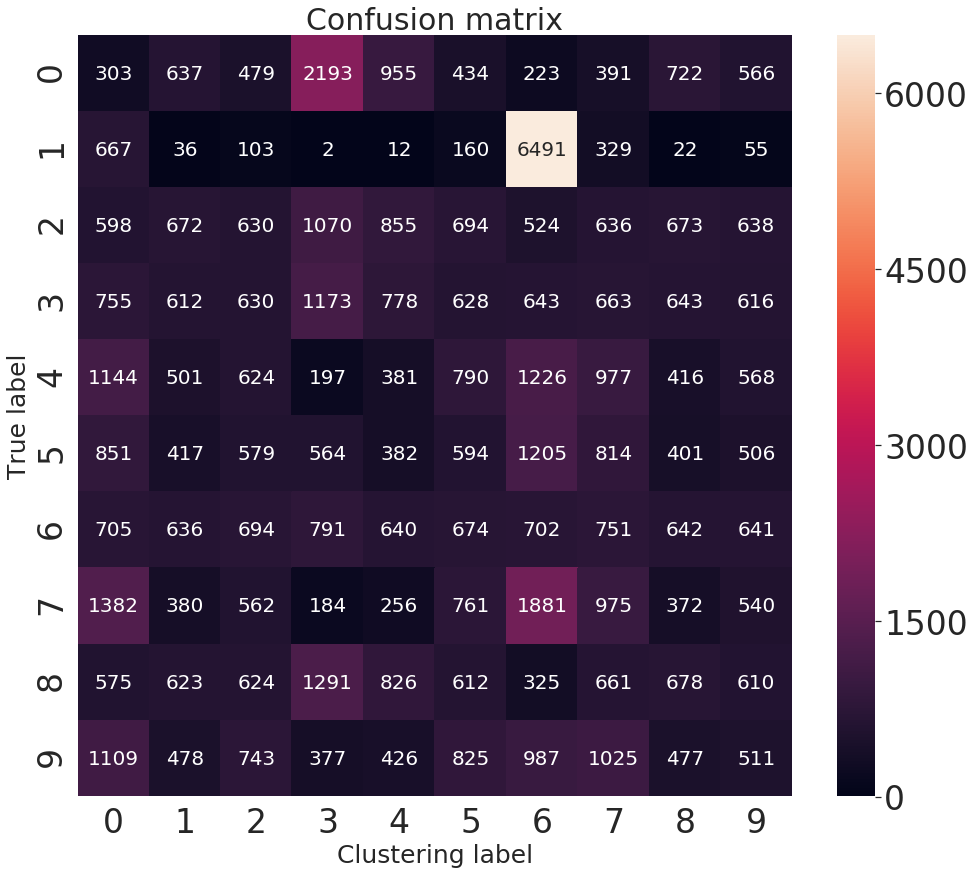

In [55]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Model to train clustering and autoencoder at same time(Convolutional)
Multiple outputs model.

In [19]:
autoencoder, encoder = autoencoderConv2D_1()
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
                           outputs=[clustering_layer, autoencoder.output])

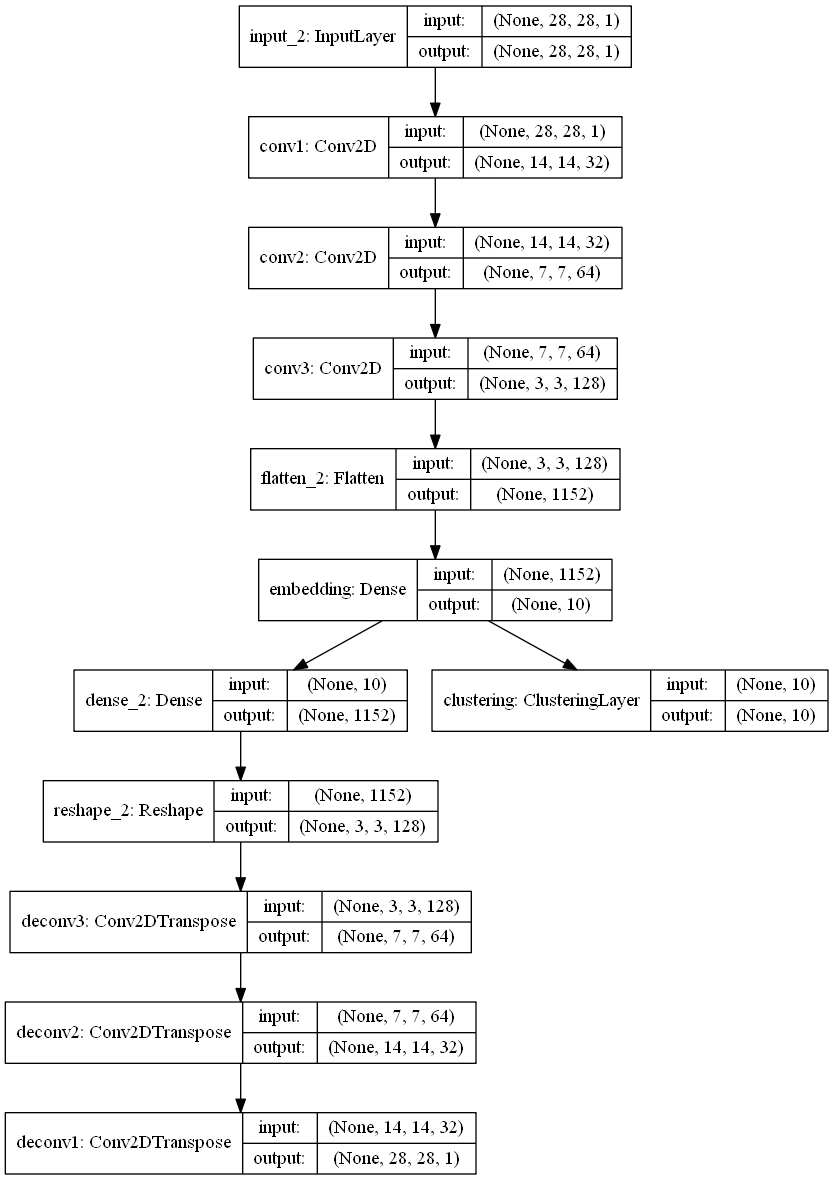

In [20]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 


### Initialize cluster centers using k-means

In [21]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [22]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/conv_b_DEC_model_final.h5')

### Load the clustering model trained weights

In [26]:
model.load_weights(save_dir + '/conv_b_DEC_model_final.h5')

### Final Evaluation

In [27]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.82233, nmi = 0.80238, ari = 0.73511  ; loss= 0


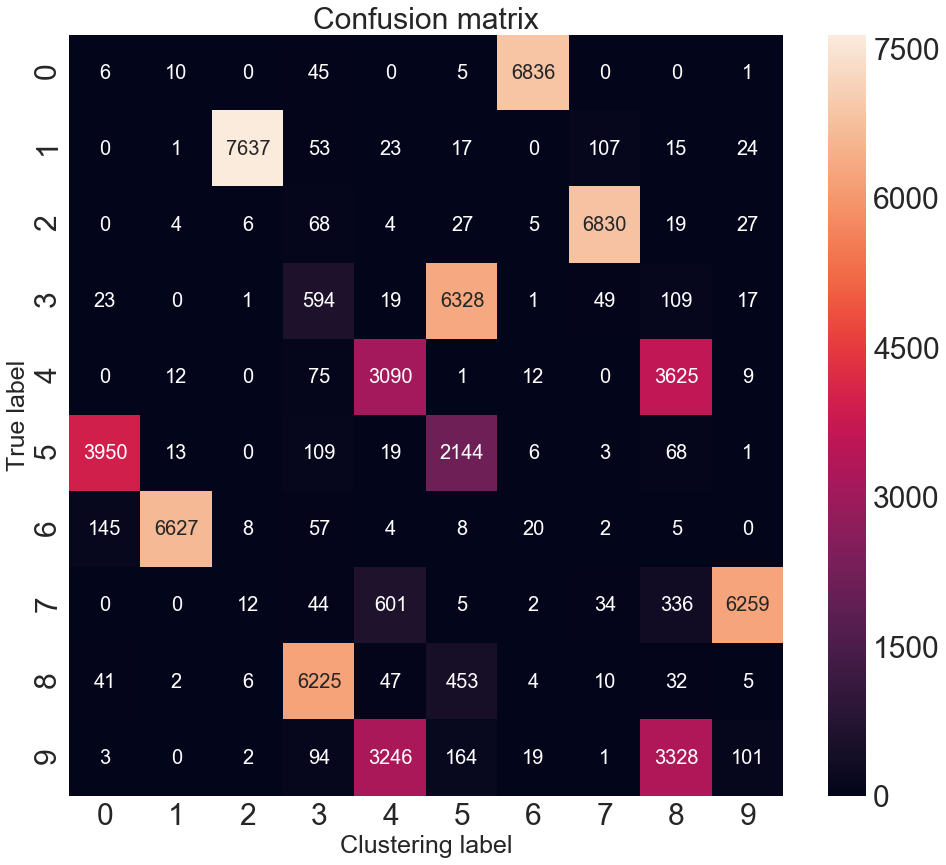

In [28]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Model to train clustering and autoencoder at same time(Fully connected)
Multiple outputs model.

In [63]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)
n_clusters = len(np.unique(y))
x.shape

(70000, 784)

In [64]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = './results'

In [93]:

def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [94]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.load_weights(save_dir+'/ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
            outputs=[clustering_layer, autoencoder.output])

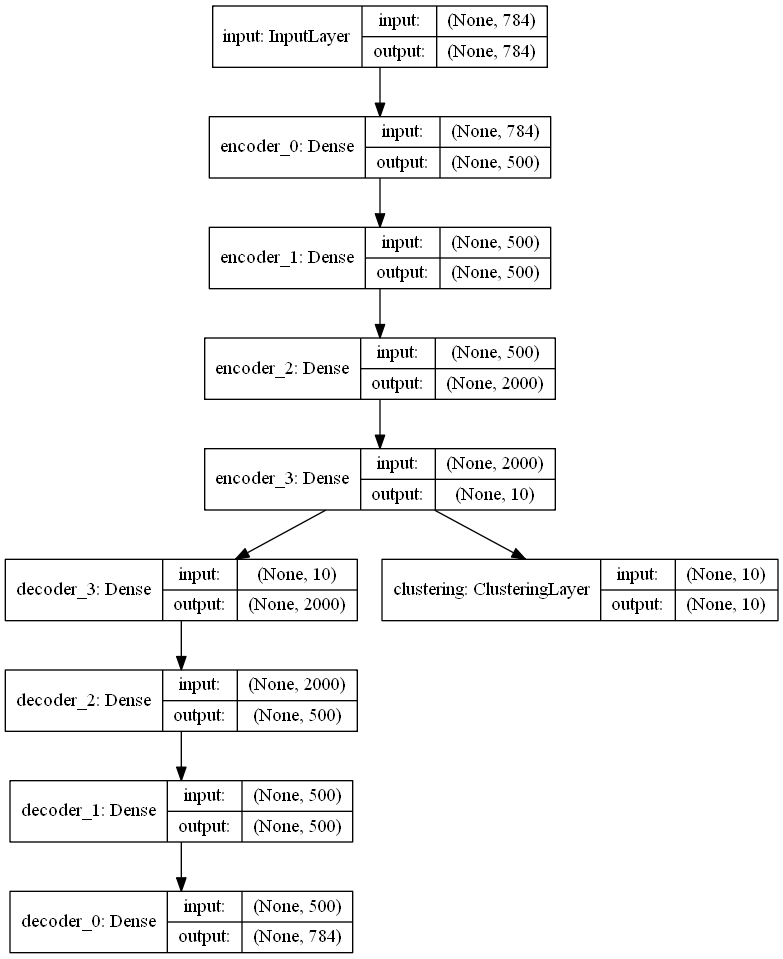

In [95]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

### Initialize cluster centers using k-means

In [96]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [98]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

### Load the clustering model trained weights

In [100]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')

### Final Evaluation

In [101]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.95587, nmi = 0.89625, ari = 0.90499  ; loss= 0


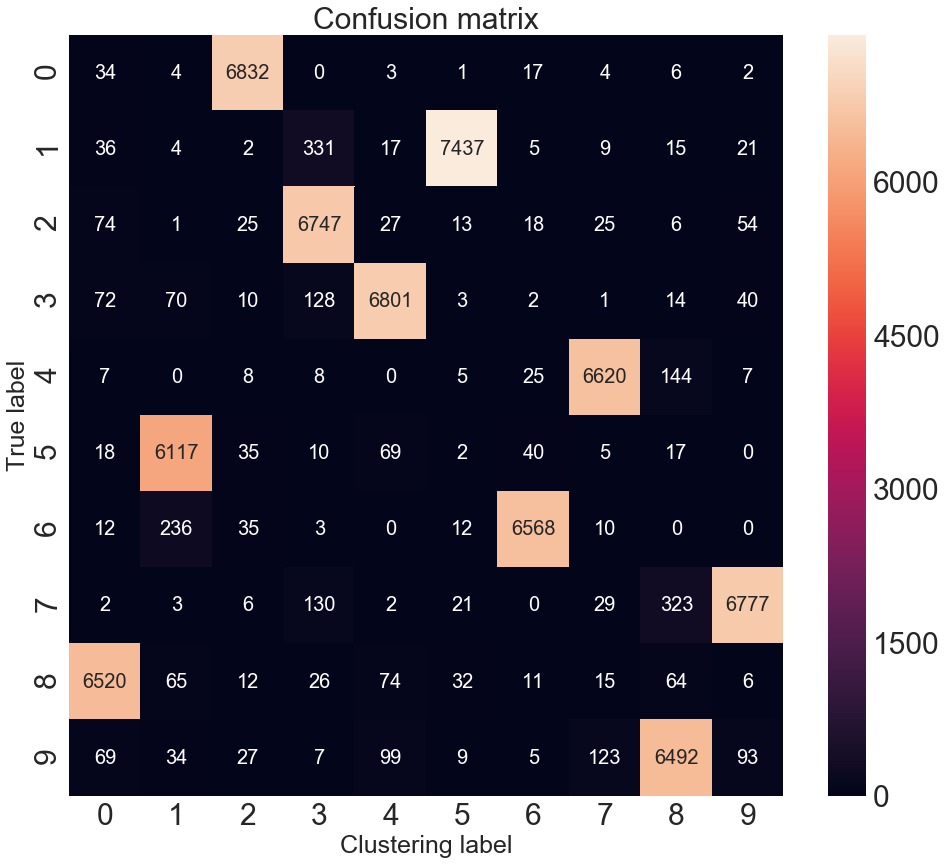

In [102]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()